In [2]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from utils import test_agent, plot_stats, seed_everything

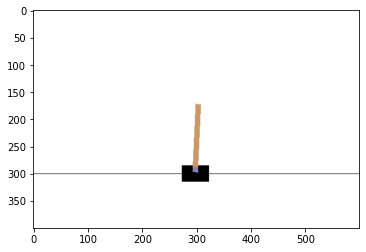

In [20]:
env = gym.make('CartPole-v0')
env.reset()
plt.imshow(env.render(mode='rgb_array'))

In [22]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"state dims {state_dims} / num actions {num_actions}" )

state dims 4 / num actions 2


In [24]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [25]:
env = PreprocessEnv(env)

In [27]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[0.0057, 0.0080, 0.0038, 0.0185]])
Next state: tensor([[ 0.0058, -0.1871,  0.0042,  0.3124]]), Reward: tensor([[1.]]), Done: tensor([[False]])


In [28]:
q_network = nn.Sequential(
    # nn.Linear state * W + b
    nn.Linear(state_dims, 128),
    # nn.ReLu max(0, state * W + b)
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
)

In [29]:
target_q_network = copy.deepcopy(q_network)
target_q_network = target_q_network.eval()
target_q_network

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [30]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

In [31]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [34]:
def deep_q_learning(q_network, policy, episodes, alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.05):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory(capacity = 1000000)
    stats = {'MSE Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0.

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)

                next_qsa_b = target_q_network(next_state_b)
                next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]
                
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
        
                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [36]:
stats = deep_q_learning(q_network, policy, 500)

100%|██████████| 500/500 [01:12<00:00,  6.86it/s]


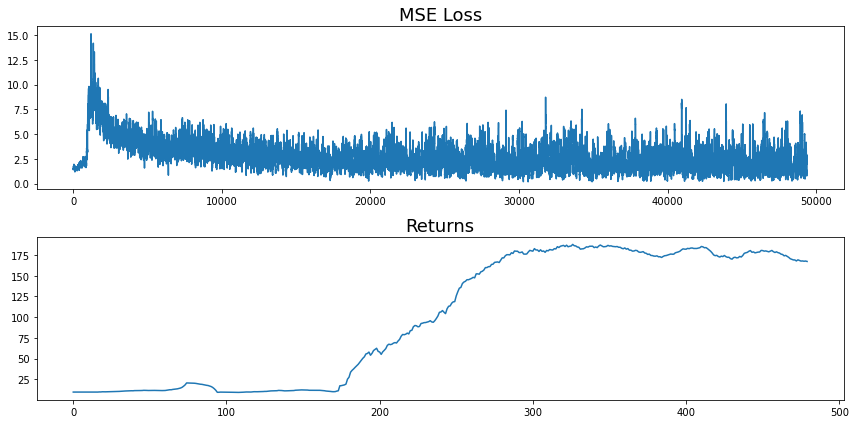

In [38]:
plot_stats(stats)

In [ ]:
test_agent(env, policy, episodes=2)